### Imports

In [27]:
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from utils.utils_go import *

# import hdbscan
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pingouin as pg
import sys

# %load_ext autotime

### Parameters

In [28]:
file = open("exp.json")
experiment = json.load(file)
exp_num = experiment["exp"]

file = open("output/{}/parameters.json".format(exp_num))
params = json.load(file)

exp = params["exp"]
print("Exp:\t\t", exp)

method = "greedy"
print("Method:\t\t", method)

data_variations = ["none"]
print("Data variations:", data_variations)

threshold_corr = params["threshold_corr"]
print("Threshold corr:\t", threshold_corr)

groups_id = params["groups_id"]
print("Groups id:\t", groups_id)

subgroups_id = params["subgroups_id"]
print("Subgroups id:\t", subgroups_id)

Exp:		 exp11
Method:		 greedy
Data variations: ['none']
Threshold corr:	 0.01
Groups id:	 ['HN', 'HV']
Subgroups id:	 {'HN': ['1', '2'], 'HV': ['1', '2']}


### Get common subgraphs

  0%|          | 0/2 [00:00<?, ?it/s]

HN 1
N° nodes:  5
N° edges:  10


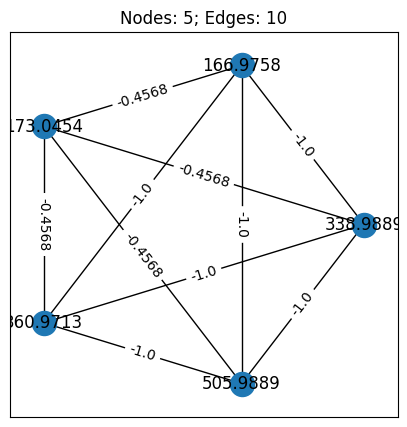

HN 2
N° nodes:  6
N° edges:  15


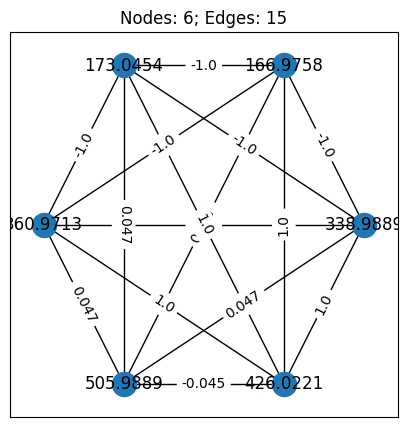

 50%|█████     | 1/2 [00:01<00:01,  1.33s/it]

HV 1
N° nodes:  0
N° edges:  0


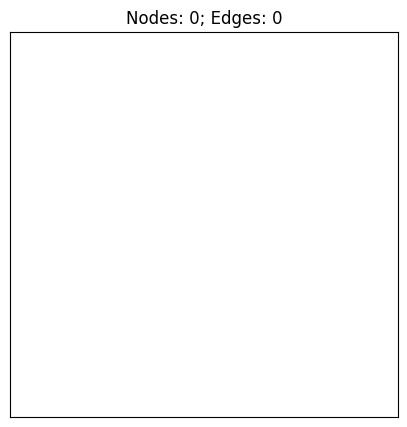

HV 2
N° nodes:  0
N° edges:  0


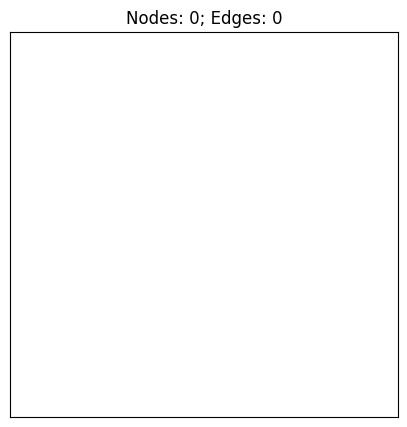

100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


In [29]:
# read edges
dict_graphs = {}

for group in tqdm(groups_id):
    graphs = []
    for subgroup in tqdm(subgroups_id[group]):
        df_edges = pd.read_csv("output/{}/preprocessing/edges/edges_{}_{}.csv".format(exp, group, subgroup))
        G = nx.from_pandas_edgelist(df_edges, "source", "target", edge_attr="weight")
        # graph_detail(G)
        graphs.append(G)

        print(group, subgroup)
        graph_partial_detail(G, edges=True)
    
    dict_graphs[group] = graphs

In [30]:
# get subgraphs

dict_df_edges_filter = get_subgraphs_global(dict_graphs, groups_id)

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Num. nodes: 688
Num. edges: 235512



100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

Num. nodes: 230
Num. edges: 25640



In [31]:
df_edges_filter = dict_df_edges_filter[groups_id[0]]
df_edges_filter.head()

,source,target
0,97,1213
1,97,71
2,97,489
3,97,302
4,97,115


### New correlation

In [32]:
# read raw data
df_join_raw = pd.read_csv("input/{}_raw.csv".format(exp), index_col=0)
# df_join_raw.index = df_join_raw.index.astype("str")
df_join_raw = df_join_raw.iloc[:, 2:]
df_join_raw

,HN_1.1,HN_1.2,HN_1.3,HN_2.1,HN_2.2,HN_2.3,HV_1.1,HV_1.2,HV_1.3,HV_2.1,HV_2.3,HV_2.4,HV_2.5
0,173.67982,1.17128,1.17128,1.17128,1.17128,117.12768,1.17128,1.17128,1.17128,1.17128,1.17128,1.17128,1.17128
1,241.33417,2.41334,2.41334,2.41334,2.41334,306.20944,2.41334,2.41334,2.41334,2.41334,2.41334,2.41334,2.41334
2,3.46233,3.46233,3.46233,3.46233,3.46233,346.23291,3.46233,3.46233,3.46233,3.46233,3.46233,3.46233,3.46233
3,117.64917,1.17649,1.17649,1.17649,1.17649,132.44109,1.17649,1.17649,1.17649,1.17649,1.17649,1.17649,1.17649
4,144.98218,1.44982,1.44982,230.19943,1.44982,1.44982,1.44982,1.44982,1.44982,1.44982,1.44982,1.44982,1.44982
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,1.96126,1.96126,1.96126,1.96126,1.96126,1.96126,1.96126,1.96126,1.96126,196.12572,1.96126,1.96126,1.96126
1858,1.00339,1.00339,1.00339,346.97250,100.33888,183.92720,1.00339,1.00339,1.00339,1.00339,1.00339,1.00339,1.00339
1859,1.39055,1.39055,1.39055,1.39055,139.05484,1.39055,1.39055,1.39055,1.39055,1.39055,1.39055,1.39055,1.39055
1860,1.77838,606.15350,177.83754,703.60211,1.77838,1.77838,1.77838,1.77838,1.77838,1.77838,1.77838,1.77838,1.77838


In [33]:
# log10
df_join_raw_log = log10_global(df_join_raw)
df_join_raw_log.head()

,HN_1.1,HN_1.2,HN_1.3,HN_2.1,HN_2.2,HN_2.3,HV_1.1,HV_1.2,HV_1.3,HV_2.1,HV_2.3,HV_2.4,HV_2.5
0,2.239749,0.068661,0.068661,0.068661,0.068661,2.068660,0.068661,0.068661,0.068661,0.068661,0.068661,0.068661,0.068661
1,2.382619,0.382619,0.382619,0.382619,0.382619,2.486019,0.382619,0.382619,0.382619,0.382619,0.382619,0.382619,0.382619
2,0.539368,0.539368,0.539368,0.539368,0.539368,2.539368,0.539368,0.539368,0.539368,0.539368,0.539368,0.539368,0.539368
3,2.070589,0.070588,0.070588,0.070588,0.070588,2.122023,0.070588,0.070588,0.070588,0.070588,0.070588,0.070588,0.070588
4,2.161315,0.161314,0.161314,2.362104,0.161314,0.161314,0.161314,0.161314,0.161314,0.161314,0.161314,0.161314,0.161314


In [34]:
# correlation
dict_df_corr = {}
for group in tqdm(groups_id):
    # graph filter
    df_edges_filter = dict_df_edges_filter[group]
    G = nx.from_pandas_edgelist(df_edges_filter.iloc[:, [0, 1]])
    nodes = list(G.nodes())
    
    df_join_raw_filter = df_join_raw_log.loc[nodes, :]
    # df_join_raw_filter = df_join_raw_filter.filter(regex=group, axis=1)
    df_join_raw_filter = df_join_raw_filter.filter(like=group, axis=1)

    df_join_raw_filter_t= df_join_raw_filter.T
    # df_join_raw_filter_corr = df_join_raw_filter_t.corr(method="pearson")
    df_join_raw_filter_corr = pg.pcorr(df_join_raw_filter_t)
    dict_df_corr[group] = df_join_raw_filter_corr

100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

HN
N° nodes:  5
N° edges:  10


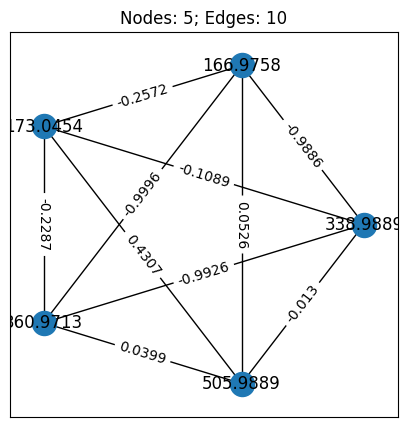

 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

HV
N° nodes:  0
N° edges:  0


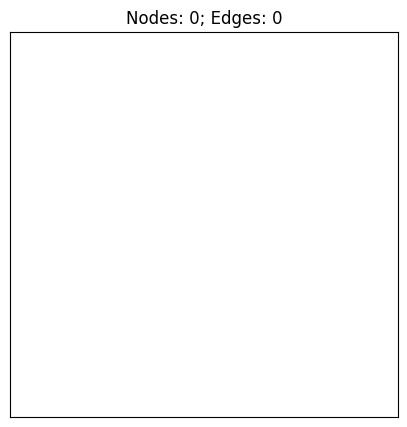

100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


In [35]:
# get new correlation
dict_df_edges_filter_weight = {}
for group in tqdm(groups_id):
    df_edges_filter_weight = dict_df_edges_filter[group].copy()
    df_corr = dict_df_corr[group]
    
    df_edges_filter_weight["weight"] = df_edges_filter_weight.apply(lambda x: df_corr.loc[x["source"], x["target"]], axis=1)
    df_edges_filter_weight.sort_values(["source", "target"], ascending=True, inplace=True)
    dict_df_edges_filter_weight[group] = df_edges_filter_weight
    # df_edges_filter_weight.to_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, method, group, option), index=False)

    print(group)
    G = nx.from_pandas_edgelist(dict_df_edges_filter_weight[group], "source", "target", edge_attr="weight")
    graph_partial_detail(G, edges=True)

In [36]:
df_edges_filter_weight = dict_df_edges_filter_weight[groups_id[0]]
df_edges_filter_weight

,source,target,weight
18411,0,1,-0.988613
18790,0,2,-0.108862
18170,0,3,-0.992602
18206,0,4,-0.012996
18778,0,10,-0.093735
...,...,...,...
40190,1860,1817,-0.252247
40309,1860,1826,0.278592
40003,1860,1834,0.039075
40347,1860,1841,0.110861


In [37]:
# filter by abs(weight) >= threshold
for group in tqdm(groups_id):
    df_edges_filter_weight = dict_df_edges_filter_weight[group]
    df_edges_filter_weight_filter = df_edges_filter_weight[df_edges_filter_weight["weight"].abs() >= threshold_corr]
    df_edges_filter_weight_filter.to_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, method, group, data_variations[0]), index=False)

100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


In [38]:
df_edges_filter_weight_filter = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, method, groups_id[0], data_variations[0]))
df_edges_filter_weight_filter

,source,target,weight
0,0,1,-0.988613
1,0,2,-0.108862
2,0,3,-0.992602
3,0,4,-0.012996
4,0,10,-0.093735
...,...,...,...
232664,1860,1817,-0.252247
232665,1860,1826,0.278592
232666,1860,1834,0.039075
232667,1860,1841,0.110861


HN
N° nodes:  5
N° edges:  10


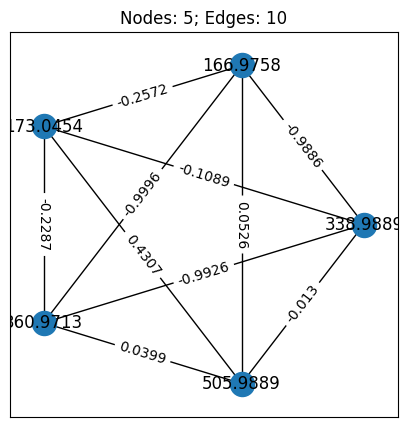

HV
N° nodes:  0
N° edges:  0


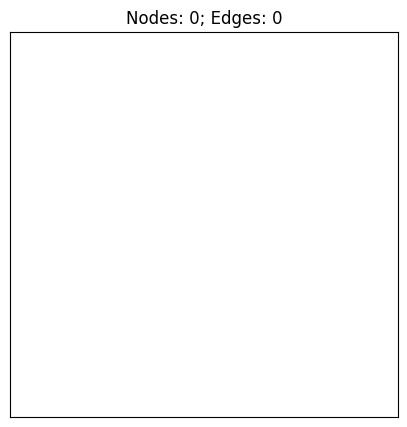

In [39]:
# final greedy
for k, group in enumerate(groups_id):
    df_edges_filter_weight_filter = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, method, group, data_variations[0]))
    # print(df_edges_filter_weight_filter)

    G = nx.from_pandas_edgelist(df_edges_filter_weight_filter, edge_attr=["weight"])
    print(group)
    graph_partial_detail(G, edges=True)